In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

In [2]:
from google.colab import files
import io
import re

In [3]:
uploaded = files.upload()

Saving THEREL~1.CSV to THEREL~1 (1).CSV


In [4]:
filename = next(iter(uploaded))

In [5]:
df = pd.read_csv(io.BytesIO(uploaded[filename]))

In [6]:
df.head(5)

,Timestamp,"\nConsent Statement \nBy clicking ""I AGREE"" below, you are indicating that:\n- I have read and understood the information provided in this consent form \n- I understand that my participation is completely voluntary \n- I am 18 years of age or older \n- I am a currently enrolled student at Strathmore University \n- I understand that I can withdraw at any time without penalty \n- I understand that this survey is anonymous and confidential \n- I voluntarily agree to participate in this research study",1. What is your age?,2. What is your gender?,3. What year of study are you currently in?,4. What is your school/faculty?,"5. On average, how many hours of sleep do you get per night on weekdays (Monday-Friday)?","6. On average, how many hours of sleep do you get per night on weekends (Saturday-Sunday)?","7. Overall, considering both weekdays and weekends, what is your average nightly sleep duration?","8. On average, how many cups or servings of caffeinated beverages do you consume per day?",...,"11. Feeling nervous, anxious, or on edge",12. Not being able to stop or control worrying,13. Worrying too much about different things,14. Trouble relaxing,15. Being so restless that it's hard to sit still,16. Becoming easily annoyed or irritable,17. Feeling afraid as if something awful might happen,18. Are you currently taking any medication for anxiety or depression?,19. Have you ever been diagnosed with an anxiety disorder by a healthcare professional?,"20. Is there anything else you would like to share about your sleep habits, caffeine consumption, or mental health that might be relevant to this study?"
0,2025/11/03 8:42:34 AM GMT+3,I AGREE - CONTINUE TO SURVEY,18.0,Male,First year,IMT,4 to 4.5 hours,7 to 7.5 hours,5 to 5.5 hours,6 or more cups per day,...,Not at all,Several days,Several days,Not at all,Not at all,Several days,Not at all,Yes,Prefer not to say,NaN
1,2025/11/03 8:42:36 AM GMT+3,I AGREE - CONTINUE TO SURVEY,20.0,Male,Second year,SFAE,7 to 7.5 hours,9 to 9.5 hours,7 to 7.5 hours,1 cup per day,...,Not at all,Not at all,Several days,Not at all,Not at all,Not at all,Several days,No,Prefer not to say,NaN
2,2025/11/03 8:42:39 AM GMT+3,I AGREE - CONTINUE TO SURVEY,20.0,Prefer not to say,Third year,SBS,7 to 7.5 hours,8 to 8.5 hours,6 to 6.5 hours,2 cups per day,...,Several days,Several days,Nearly every day,Nearly every day,More than half the days,Nearly every day,Nearly every day,NaN,NaN,NaN
3,2025/11/03 8:42:41 AM GMT+3,I AGREE - CONTINUE TO SURVEY,21.0,Female,Third year,SCES,7 to 7.5 hours,8 to 8.5 hours,10 hours or more,Less than 1 cup per day,...,Several days,Not at all,Several days,Several days,Not at all,Several days,Not at all,Prefer not to say,NaN,NaN
4,2025/11/03 8:42:43 AM GMT+3,I AGREE - CONTINUE TO SURVEY,21.0,Prefer not to say,Fourth year,SHSS,6 to 6.5 hours,7 to 7.5 hours,6 to 6.5 hours,1 cup per day,...,Not at all,More than half the days,More than half the days,Nearly every day,Several days,Nearly every day,Several days,NaN,No,NaN


In [7]:
def clean_caffeine(val):
    if pd.isna(val): return np.nan
    val = str(val).lower()
    if 'less than 1' in val: return 0.5
    if '0 (' in val: return 0
    if '6 or more' in val: return 6
    match = re.search(r'\d+', val)
    return float(match.group()) if match else np.nan

In [8]:
def clean_sleep(val):
    if pd.isna(val): return np.nan
    val = str(val).lower()
    if 'or more' in val:
        match = re.search(r'\d+', val)
        return float(match.group()) if match else np.nan
    if 'to' in val:
        parts = re.findall(r"[\d\.]+", val)
        if len(parts) >= 2: return (float(parts[0]) + float(parts[1])) / 2
        return float(parts[0])
    return np.nan

In [9]:
df.rename(columns={
    '7. Overall, considering both weekdays and weekends, what is your average nightly sleep duration?': 'Sleep_Overall',
    '8. On average, how many cups or servings of caffeinated beverages do you consume per day? ': 'Caffeine_Cups'
}, inplace=True)

In [10]:
df['Caffeine_Clean'] = df['Caffeine_Cups'].apply(clean_caffeine)
df['Sleep_Clean'] = df['Sleep_Overall'].apply(clean_sleep)

In [11]:
gad_map = {'Not at all': 0, 'Several days': 1, 'More than half the days': 2, 'Nearly every day': 3}
gad_cols = df.columns[12:19]
for col in gad_cols:
    print(f" - {col[:30]}...")
    df[col] = df[col].astype(str).str.strip().map(gad_map)

 - 11. Feeling nervous, anxious, ...
 - 12. Not being able to stop or ...
 - 13. Worrying too much about di...
 - 14. Trouble relaxing ...
 - 15. Being so restless that it'...
 - 16. Becoming easily annoyed or...
 - 17. Feeling afraid as if somet...


In [12]:
df['Anxiety_Score'] = df[gad_cols].sum(axis=1)

In [14]:
df.head(10)

,Timestamp,"\nConsent Statement \nBy clicking ""I AGREE"" below, you are indicating that:\n- I have read and understood the information provided in this consent form \n- I understand that my participation is completely voluntary \n- I am 18 years of age or older \n- I am a currently enrolled student at Strathmore University \n- I understand that I can withdraw at any time without penalty \n- I understand that this survey is anonymous and confidential \n- I voluntarily agree to participate in this research study",1. What is your age?,2. What is your gender?,3. What year of study are you currently in?,4. What is your school/faculty?,"5. On average, how many hours of sleep do you get per night on weekdays (Monday-Friday)?","6. On average, how many hours of sleep do you get per night on weekends (Saturday-Sunday)?",Sleep_Overall,Caffeine_Cups,...,14. Trouble relaxing,15. Being so restless that it's hard to sit still,16. Becoming easily annoyed or irritable,17. Feeling afraid as if something awful might happen,18. Are you currently taking any medication for anxiety or depression?,19. Have you ever been diagnosed with an anxiety disorder by a healthcare professional?,"20. Is there anything else you would like to share about your sleep habits, caffeine consumption, or mental health that might be relevant to this study?",Caffeine_Clean,Sleep_Clean,Anxiety_Score
0,2025/11/03 8:42:34 AM GMT+3,I AGREE - CONTINUE TO SURVEY,18.0,Male,First year,IMT,4 to 4.5 hours,7 to 7.5 hours,5 to 5.5 hours,6 or more cups per day,...,0.0,0.0,1.0,0.0,Yes,Prefer not to say,NaN,6.0,5.25,3.0
1,2025/11/03 8:42:36 AM GMT+3,I AGREE - CONTINUE TO SURVEY,20.0,Male,Second year,SFAE,7 to 7.5 hours,9 to 9.5 hours,7 to 7.5 hours,1 cup per day,...,0.0,0.0,0.0,1.0,No,Prefer not to say,NaN,1.0,7.25,2.0
2,2025/11/03 8:42:39 AM GMT+3,I AGREE - CONTINUE TO SURVEY,20.0,Prefer not to say,Third year,SBS,7 to 7.5 hours,8 to 8.5 hours,6 to 6.5 hours,2 cups per day,...,3.0,2.0,3.0,3.0,NaN,NaN,NaN,2.0,6.25,16.0
3,2025/11/03 8:42:41 AM GMT+3,I AGREE - CONTINUE TO SURVEY,21.0,Female,Third year,SCES,7 to 7.5 hours,8 to 8.5 hours,10 hours or more,Less than 1 cup per day,...,1.0,0.0,1.0,0.0,Prefer not to say,NaN,NaN,0.5,10.00,4.0
4,2025/11/03 8:42:43 AM GMT+3,I AGREE - CONTINUE TO SURVEY,21.0,Prefer not to say,Fourth year,SHSS,6 to 6.5 hours,7 to 7.5 hours,6 to 6.5 hours,1 cup per day,...,3.0,1.0,3.0,1.0,NaN,No,NaN,1.0,6.25,12.0
5,2025/11/03 8:42:46 AM GMT+3,I AGREE - CONTINUE TO SURVEY,20.0,Female,Third year,IMT,6 to 6.5 hours,7 to 7.5 hours,6 to 6.5 hours,3 cups per day,...,2.0,2.0,2.0,2.0,NaN,Yes,NaN,3.0,6.25,16.0
6,2025/11/03 8:42:49 AM GMT+3,I DO NOT AGREE - EXIT SURVEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7,2025/11/03 8:42:51 AM GMT+3,I DO NOT AGREE - EXIT SURVEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8,2025/11/03 8:42:53 AM GMT+3,I AGREE - CONTINUE TO SURVEY,21.0,Female,Fourth year,SBS,4 to 4.5 hours,7 to 7.5 hours,5 to 5.5 hours,3 cups per day,...,0.0,0.0,1.0,0.0,Yes,NaN,NaN,3.0,5.25,4.0
9,2025/11/03 8:42:56 AM GMT+3,I AGREE - CONTINUE TO SURVEY,20.0,Prefer not to say,Second year,SBS,10 hours or more,9 to 9.5 hours,7 to 7.5 hours,Less than 1 cup per day,...,1.0,0.0,0.0,1.0,NaN,Yes,NaN,0.5,7.25,3.0


In [15]:
df_clean = df.dropna(subset=['Sleep_Clean', 'Caffeine_Clean', 'Anxiety_Score'])

In [16]:
columns_to_keep = [
    '1. What is your age?',
    '2. What is your gender?',
    '3. What year of study are you currently in?',
    '4. What is your school/faculty?',
    'Sleep_Clean',
    'Caffeine_Clean',
    'Anxiety_Score'
]

In [17]:
final_df = df[columns_to_keep].copy()

In [18]:
final_df.rename(columns={
    '1. What is your age?': 'Age',
    '2. What is your gender?': 'Gender',
    '3. What year of study are you currently in?': 'Year',
    '4. What is your school/faculty?': 'School'
}, inplace=True)

In [19]:
final_df.head()

,Age,Gender,Year,School,Sleep_Clean,Caffeine_Clean,Anxiety_Score
0,18.0,Male,First year,IMT,5.25,6.0,3.0
1,20.0,Male,Second year,SFAE,7.25,1.0,2.0
2,20.0,Prefer not to say,Third year,SBS,6.25,2.0,16.0
3,21.0,Female,Third year,SCES,10.00,0.5,4.0
4,21.0,Prefer not to say,Fourth year,SHSS,6.25,1.0,12.0


In [20]:
def cronbach_alpha(df, cols):
    item_scores = df[cols].dropna()
    item_variances = item_scores.var(axis=0, ddof=1)
    total_score_variance = item_scores.sum(axis=1).var(ddof=1)
    n = len(cols)
    return (n / (n - 1)) * (1 - (item_variances.sum() / total_score_variance))

alpha = cronbach_alpha(df, gad_cols)
print(f"Cronbach's Alpha (Reliability): {alpha:.3f}")

Cronbach's Alpha (Reliability): 0.902


In [21]:
final_df = final_df.dropna(subset=['Sleep_Clean', 'Caffeine_Clean', 'Anxiety_Score'])

In [22]:
final_df.head()

,Age,Gender,Year,School,Sleep_Clean,Caffeine_Clean,Anxiety_Score
0,18.0,Male,First year,IMT,5.25,6.0,3.0
1,20.0,Male,Second year,SFAE,7.25,1.0,2.0
2,20.0,Prefer not to say,Third year,SBS,6.25,2.0,16.0
3,21.0,Female,Third year,SCES,10.00,0.5,4.0
4,21.0,Prefer not to say,Fourth year,SHSS,6.25,1.0,12.0


In [23]:
final_df[['Sleep_Clean', 'Caffeine_Clean', 'Anxiety_Score']].describe()

,Sleep_Clean,Caffeine_Clean,Anxiety_Score
count,28.00000,28.000000,28.000000
mean,7.00000,1.750000,9.428571
std,1.49691,1.663887,6.448822
min,5.25000,0.000000,1.000000
25%,6.25000,0.500000,3.000000
50%,6.25000,1.000000,9.000000
75%,7.25000,3.000000,16.000000
max,10.00000,6.000000,19.000000


In [24]:
final_df[['Sleep_Clean', 'Caffeine_Clean', 'Anxiety_Score']].corr()

,Sleep_Clean,Caffeine_Clean,Anxiety_Score
Sleep_Clean,1.000000,-0.529751,-0.515080
Caffeine_Clean,-0.529751,1.000000,0.205376
Anxiety_Score,-0.515080,0.205376,1.000000


In [27]:
corr_matrix = final_df[['Sleep_Clean', 'Caffeine_Clean', 'Anxiety_Score']].corr()

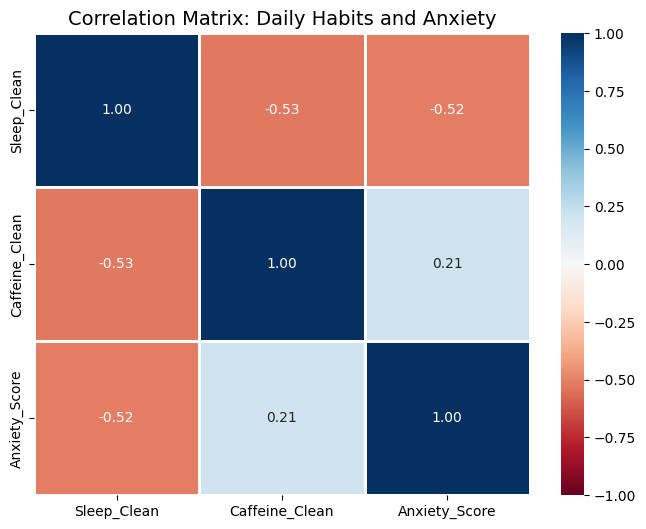

In [28]:
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(corr_matrix,
                      annot=True,    # Show the numbers
                      cmap='RdBu',   # Red-Blue color scheme (Standard for scientific papers)
                      vmin=-1, vmax=1, # Scale from -1 to +1
                      center=0,      # Center the colormap at 0
                      fmt='.2f',     # Format to 2 decimal places
                      linewidths=1, linecolor='white')

plt.title('Correlation Matrix: Daily Habits and Anxiety', fontsize=14)
plt.show()

In [25]:
print("\n--- Regression Analysis ---")
X = final_df[['Sleep_Clean', 'Caffeine_Clean']]
Y = final_df['Anxiety_Score']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())


--- Regression Analysis ---
                            OLS Regression Results                            
Dep. Variable:          Anxiety_Score   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     4.662
Date:                Thu, 20 Nov 2025   Prob (F-statistic):             0.0190
Time:                        01:22:45   Log-Likelihood:                -86.973
No. Observations:                  28   AIC:                             179.9
Df Residuals:                      25   BIC:                             183.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          

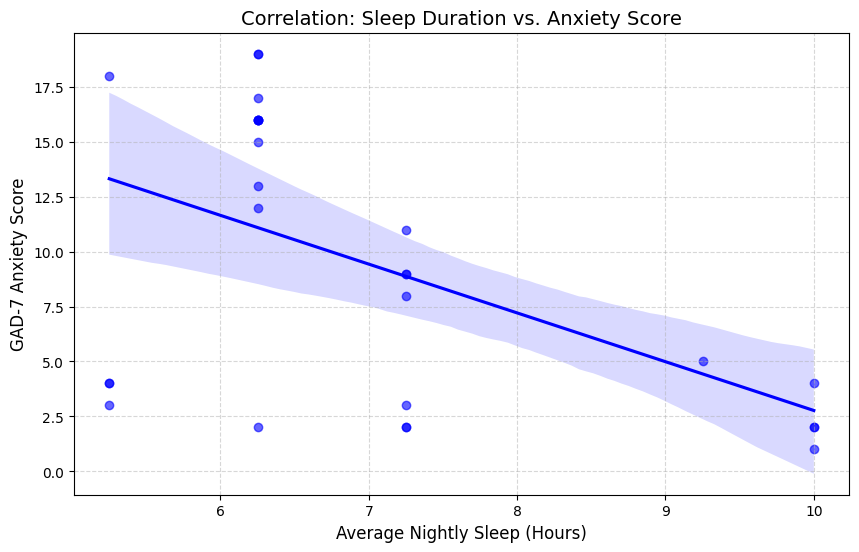

In [26]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Sleep_Clean', y='Anxiety_Score', data=final_df, color='blue', scatter_kws={'alpha':0.6})
plt.title('Correlation: Sleep Duration vs. Anxiety Score', fontsize=14)
plt.xlabel('Average Nightly Sleep (Hours)', fontsize=12)
plt.ylabel('GAD-7 Anxiety Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)